In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

import random
from pathlib import Path

from tqdm import tqdm
import numpy as np
import scipy as sp
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
# import pandas as pd
# pd.options.display.width = 1000

import os, sys
sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))

from vrAnalysis import analysis
from vrAnalysis import helpers
from vrAnalysis import database
from vrAnalysis import tracking
from vrAnalysis import fileManagement as fm
from vrAnalysis import faststats as fs

from vrAnalysis.syd_viewers.placecell_across_session_rel import PlaceFieldLoader, get_cell_viewer, get_summary_viewer

from syd import make_viewer

sessiondb = database.vrDatabase('vrSessions')
mousedb = database.vrDatabase('vrMice')

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
loader = PlaceFieldLoader("CR_Hippocannula7", keep_planes=[1, 2, 3, 4], sesmethod="all", onefile="mpci.roiSignificantFluorescence", summary_only=True)

In [12]:
viewer = get_cell_viewer(loader).deploy(suppress_warnings=True)

No such comm: d8c472231b204d2b9871e93c52db808a


No such comm: 1e5875fd232a4ddc81d67dba56e2c2c2


In [5]:
viewer = get_summary_viewer(loader).deploy(controls_position="right",suppress_warnings=True)

No such comm: 23b45c2bf5834b988b761e404da527ca


In [8]:
onefile = "mpci.roiSignificantFluorescence"
mouse_name = "CR_Hippocannula6"
track = tracking.tracker(mouse_name)
pcm = analysis.placeCellMultiSession(track, autoload=False, keep_planes=[1, 2], onefile=onefile)
pcss = pcm.pcss[-1]
iroi = 181

spkmap = pcss.get_spkmap(2, average=False)[0]
spks = pcss.vrexp.loadone(onefile)[:, pcss.idxUseROI]

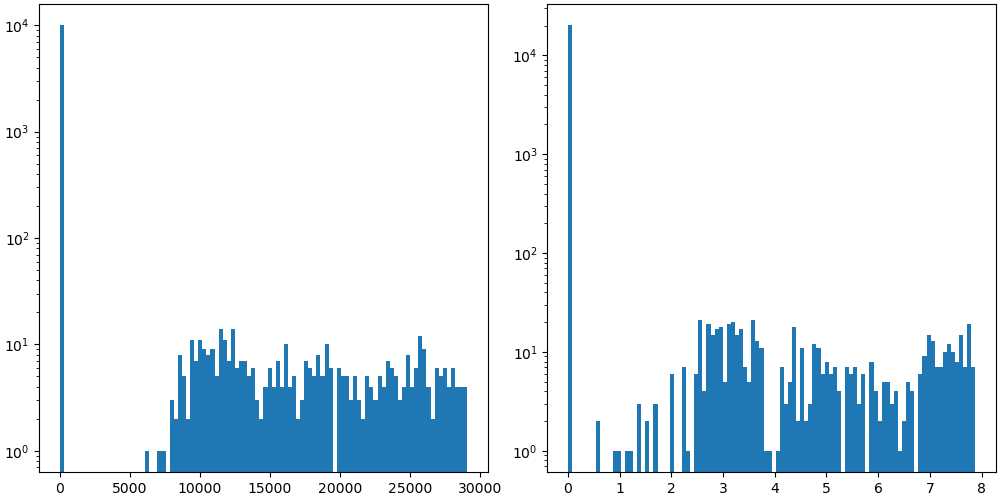

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), layout="constrained")
ax[0].hist(spks[:, iroi], bins=100, density=False)
ax[1].hist(spkmap[iroi].flatten(), bins=100, density=False)
ax[0].set_yscale("log")
ax[1].set_yscale("log")
plt.show()

In [191]:
from vrAnalysis.metrics import KernelDensityEstimator, plot_contours

activity_method = "rms"
fraction_method = "participation"
envoption = "first"

fraction_active_name = loader._fraction_active_name(activity_method, fraction_method)
fraction_active_data = loader.fraction_active[envoption][fraction_active_name]
reliability_data = np.stack(loader.extras[envoption]["relloo"], axis=1)
idx_red = np.any(np.stack([ired for ired in loader.extras[envoption]["idx_red"]]), axis=0)

colors = plt.cm.coolwarm(np.linspace(0, 1, fraction_active_data.shape[1]))
colors = colors[:, :3]


reliability_range = (-1.0, 1.0)
fraction_range = (0.0, 1.0)
nbins = 101
kde_ctl = []
kde_red = []
for i in range(fraction_active_data.shape[1]):
    kde_ctl.append(KernelDensityEstimator(reliability_data[~idx_red, i], fraction_active_data[~idx_red, i], xrange=reliability_range, yrange=fraction_range, nbins=nbins).fit())
    kde_red.append(KernelDensityEstimator(reliability_data[idx_red, i], fraction_active_data[idx_red, i], xrange=reliability_range, yrange=fraction_range, nbins=nbins).fit())

def plot(state):
    idx_ses = state["idx_ses"]
    min_level, max_level = state["level_range"]
    num_levels = state["num_levels"]
    
    levels = np.linspace(min_level, max_level, num_levels) if num_levels > 1 else [(max_level + min_level) / 2]
    contours_ctl = kde_ctl[idx_ses].contours(levels)
    contours_red = kde_red[idx_ses].contours(levels)

    contour_cmap = plt.cm.coolwarm
    colors = contour_cmap(np.linspace(0, 1, num_levels))

    fig, ax = plt.subplots(1, 3, figsize=(9, 3.5), layout="constrained")
    
    # Plot the kde estimates
    ax[0].imshow(kde_ctl[idx_ses].plot_data, cmap="gray_r", extent=kde_ctl[idx_ses].extent, aspect="auto")
    ax[1].imshow(kde_red[idx_ses].plot_data, cmap="gray_r",extent=kde_red[idx_ses].extent, aspect="auto")

    # Plot the contours
    for ctl, red, color in zip(contours_ctl, contours_red, colors):
        plot_contours(ctl, ax=ax[0], color=color, linewidth=1.0, alpha=1.0)
        plot_contours(red, ax=ax[1], color=color, linewidth=1.0, alpha=1.0)

    # Plot the difference in the distributions
    difference = kde_red[idx_ses].plot_data - kde_ctl[idx_ses].plot_data
    max_diff = np.max(np.abs(difference))
    ax[2].imshow(difference, cmap="bwr", extent=kde_red[idx_ses].extent, aspect="auto", vmin=-max_diff, vmax=max_diff)

    for a in ax:
        a.set_xlabel("Reliability")
        a.set_ylabel("Fraction Active")
        a.set_xlim(reliability_range)
        a.set_ylim(fraction_range)

    ax[0].set_title("Control Cells")
    ax[1].set_title("Red Cells")
    ax[2].set_title("Difference")

    # Boundaries for the colorbar
    inset = ax[0].inset_axes([0.05, 0.57, 0.1, 0.4])
    step_size = levels[1] - levels[0]
    color_lims = [min_level - step_size/2, max_level + step_size/2]
    yticks = levels
    max_ticks = 6
    if num_levels > max_ticks:
        from math import ceil
        step = ceil((num_levels-1)/(max_ticks-1))  # -1s ensure first/last included
        indices = list(range(0, num_levels-1, step)) + [num_levels-1]
        yticks = yticks[indices]
    inset.imshow(np.flipud(np.reshape(colors, (num_levels, 1, 4))), aspect='auto', extent=[0, 1, color_lims[0], color_lims[1]])
    inset.set_xticks([])
    inset.set_yticks(yticks)
    inset.set_yticklabels([f'{level:.2f}' for level in yticks])
    inset.yaxis.tick_right()
    return fig


viewer = make_viewer(plot)
viewer.add_integer("idx_ses", value=0, min_value=0, max_value=len(kde_ctl)-1)
viewer.add_float_range("level_range", value=(0.5, 0.9), min_value=0.0, max_value=1.0)
viewer.add_integer("num_levels", value=10, min_value=1, max_value=100)
viewer.deploy(controls_position="right")
# viewer.plot(viewer.state)

No such comm: 7e5f46e5cbae47e4b190dc382c742a8f


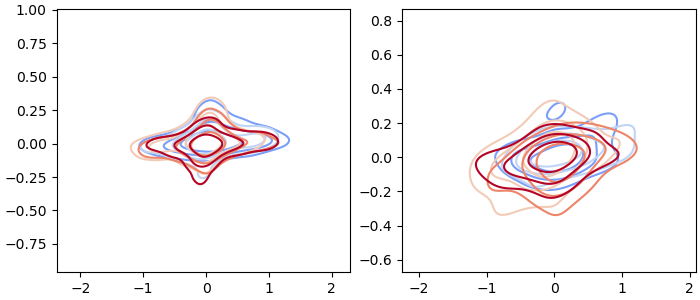

In [45]:
import seaborn as sns

diff_reliability = np.diff(reliability_data, axis=1)
diff_fraction_active = np.diff(fraction_active_data, axis=1)

levels = [0.25, 0.5, 0.75]
fig, ax = plt.subplots(1, 2, figsize=(7, 3), layout="constrained")
for i in range(diff_reliability.shape[1]):
    sns.kdeplot(x=diff_reliability[~idx_red, i], y=diff_fraction_active[~idx_red, i], ax=ax[0], levels=levels, color=colors[i+1])
    sns.kdeplot(x=diff_reliability[idx_red, i], y=diff_fraction_active[idx_red, i], ax=ax[1], levels=levels, color=colors[i+1])

plt.show()

Number of contours at low level: 1
Number of contours at mid level: 1
Number of contours at high level: 2
5.838482350139048e-06 1.0


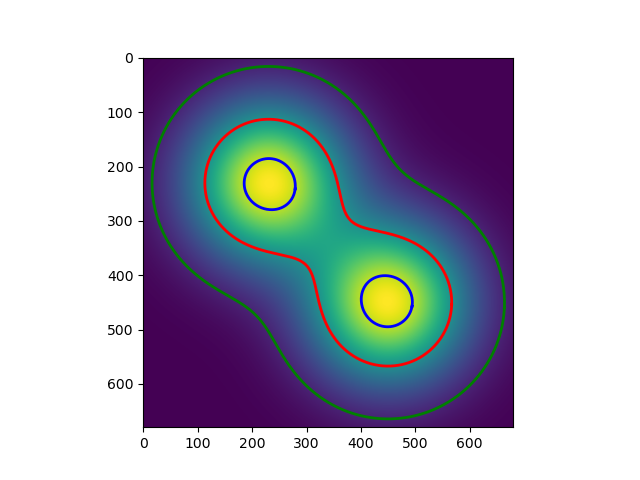

In [130]:
import numpy as np
from scipy.stats import multivariate_normal
from skimage import measure
import matplotlib.pyplot as plt

# Create a bimodal Gaussian
width = 3.4
x, y = np.mgrid[-width:width:.01, -width:width:.01]
pos = np.dstack((x, y))
offset = 1.1
variance = 1
rv1 = multivariate_normal([offset, offset], [[variance, 0], [0, variance]])

rv2 = multivariate_normal([-offset, -offset], [[variance, 0], [0, variance]])


z = rv1.pdf(pos) / np.max(rv1.pdf(pos)) + rv2.pdf(pos) / np.max(rv2.pdf(pos))
z = z / np.max(z)

# Find contours at different levels
contours_low = measure.find_contours(z, 0.1)
contours_mid = measure.find_contours(z, 0.5)
contours_high = measure.find_contours(z, 0.9)

print(f"Number of contours at low level: {len(contours_low)}")
print(f"Number of contours at mid level: {len(contours_mid)}")
print(f"Number of contours at high level: {len(contours_high)}")
print(np.min(z), np.max(z))


plt.close('all')
plt.imshow(z)

def plot_contours(contours, color='k', linewidth=2):
    for contour in contours:
        plt.plot(contour[:, 0], contour[:, 1], color=color, linewidth=linewidth)

plot_contours(contours_low, color='g', linewidth=2)
plot_contours(contours_mid, color='r', linewidth=2)
plot_contours(contours_high, color='b', linewidth=2)
plt.show()




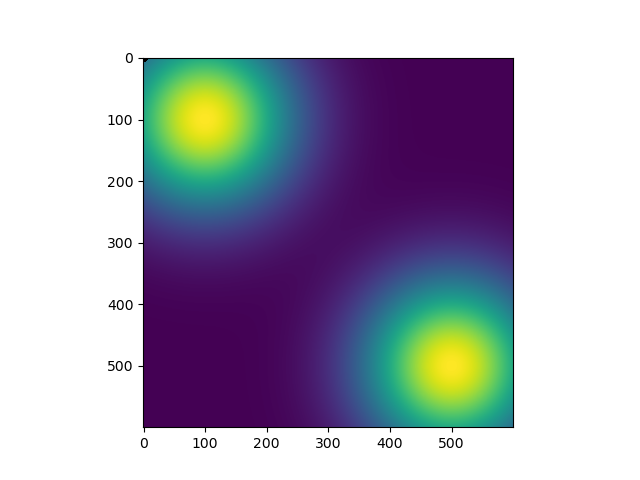

(4.659032111604948e-06, 1.0000001125351747)